<a href="https://colab.research.google.com/github/Denchil-RPG/Machine/blob/main/Lab_Banki_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit card Fraud Detector
Прокопович Д.А. БАС-21

Введение


На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

Наши цели:
Проанализировать полученные данные.
Рассмотреть проблему сильного дисбаланса классов.
Использовать алгоритмы кластеризации
Использовать алгоритмы понижения размерности
Описание данных и постановка задачи:
Задача: Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

Данные: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт. В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

Загружаем данные: 'creditcard.csv'

In [2]:
# загрузка данных и структура данных
df = pd.read_csv('creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Небольшой описательный анализ.

In [3]:
# анализ данных
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Проверим на наличие пропусков в данных.

In [4]:
# проверка наличия пропусков в данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Пропусков нет

Выведем названия столбцов.

In [5]:
# названия столбцов
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Еще раз оценим отношение классов целевой переменной.

In [6]:
# вывод на печать 'Обычные транзакции составляют' и 'Мошеннические транзакции составляют' в процентном соотношении

total_transactions = len(df)
normal_transactions = len(df[df['Class'] == 0])
fraudulent_transactions = len(df[df['Class'] == 1])

normal_percentage = (normal_transactions / total_transactions) * 100
fraudulent_percentage = (fraudulent_transactions / total_transactions) * 100

print(f'Обычные: {normal_percentage:.4f}%')
print(f'Мошеннические: {fraudulent_percentage:.4f}%')

Обычные: 99.8273%
Мошеннические: 0.1727%


In [7]:
# df['Class'].value_counts()  - возвращает словарик,
# где ключ - уникальные значения в столбце Class кол-во значений
# value - сколько всего записей имело эти значения
print(df['Class'].value_counts())

# так как это словарь, то чтобы получить значения, обращаемся по ключу:
print(df['Class'].value_counts()[0])
print(df['Class'].value_counts()[1])

Class
0    284315
1       492
Name: count, dtype: int64
284315
492


In [8]:
n_trans = len(df[df['Class'] == 0])
f_trans = len(df[df['Class'] == 1])


Важно!

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

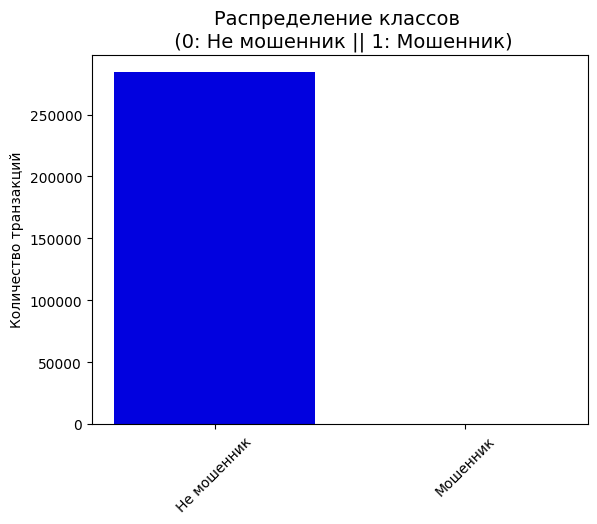

In [9]:
# Построение гистограммы
colors = ["#0101DF", "#DF0101"]
plt.bar(['Не мошенник', 'Мошенник'], [n_trans, f_trans], color=colors)
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)
plt.show()


Построим распределения по суммам и времени транзакций.

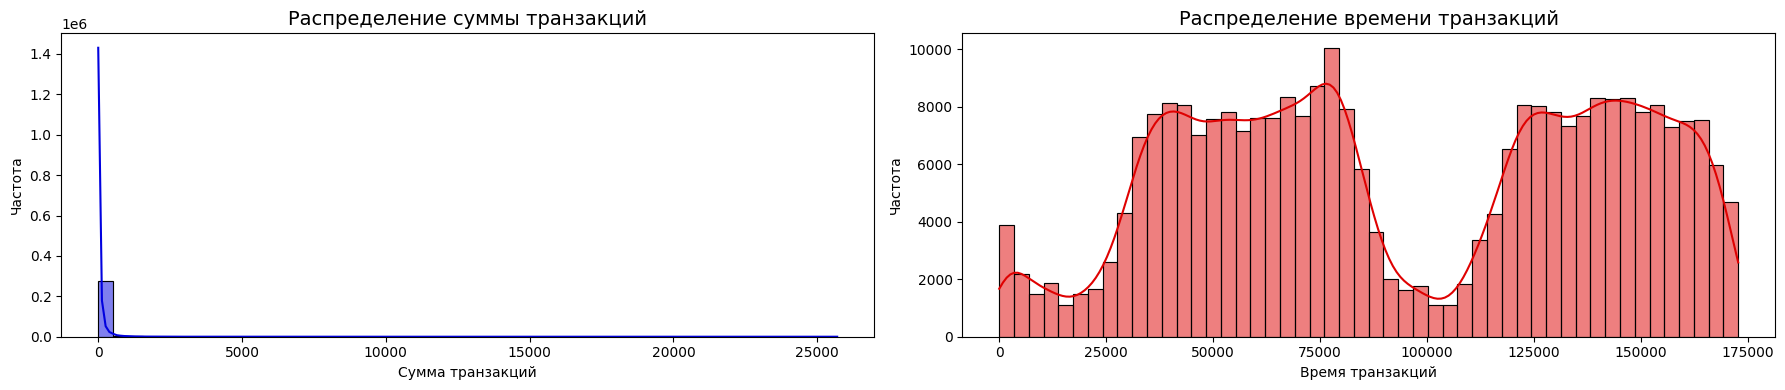

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

#Значения для суммы и времени транзакций
amount_val = df['Amount']
time_val = df['Time']

# Строим график распределения суммы транзакций
sns.histplot(amount_val, bins=50, kde=True, ax=ax[0], color='#0101DF')
ax[0].set_title('Распределение суммы транзакций', fontsize=14)
ax[0].set_xlabel('Сумма транзакций')
ax[0].set_ylabel('Частота')

# Строим график распределения времени транзакций
sns.histplot(time_val, bins=50, kde=True, ax=ax[1], color='#DF0101')
ax[1].set_title('Распределение времени транзакций', fontsize=14)
ax[1].set_xlabel('Время транзакций')
ax[1].set_ylabel('Частота')

# Показываем графики
plt.tight_layout()
plt.show()

In [11]:

from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')

# вот последнее представление - как раз то, что нужно для RobustScaler . Преобразовываем так все нужные столбцы.

original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = rob_scaler.fit_transform(original_Xtest['Amount'].values.reshape(-1,1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))
original_Xtest['scaled_time'] = rob_scaler.fit_transform(original_Xtest['Time'].values.reshape(-1,1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  9.99  45.9   11.99 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  9.99]
 [ 45.9 ]
 [ 11.99]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


Метод Random Under-Sampling

In [12]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем последние 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
253522,156294.0,2.021996,-0.224932,-1.244309,0.216455,0.035434,-0.598639,-0.003892,-0.077159,0.470474,...,-0.265387,-0.729382,0.290938,-0.495281,-0.329922,0.211092,-0.080520,-0.075617,9.99,0
195383,131024.0,0.469750,-1.237555,-1.767341,4.833490,-0.268715,-0.512760,1.140149,-0.341273,-1.046351,...,0.303905,-0.647075,-0.373014,0.260801,-0.496566,-0.245973,-0.117858,0.144774,723.21,1
183016,125619.0,2.148601,0.004208,-1.736080,0.120361,0.503625,-0.766331,0.261912,-0.362036,0.609469,...,0.180837,0.716446,-0.132735,-0.955747,0.420281,-0.047417,-0.018314,-0.068449,1.00,0
83053,59669.0,0.326007,1.286638,-2.007181,2.419675,-1.532902,-1.432803,-2.459530,0.617738,-1.125861,...,0.556895,0.169776,-0.174357,0.308061,0.710996,-0.231030,0.580495,0.300984,6.27,1
46998,43028.0,-1.109646,0.811069,-1.138135,0.935265,-2.330248,-0.116106,-1.621986,0.458028,-0.912189,...,0.641594,0.841755,0.176728,0.081004,-0.258899,0.707654,0.418649,0.080756,204.27,1


Матрица корреляций

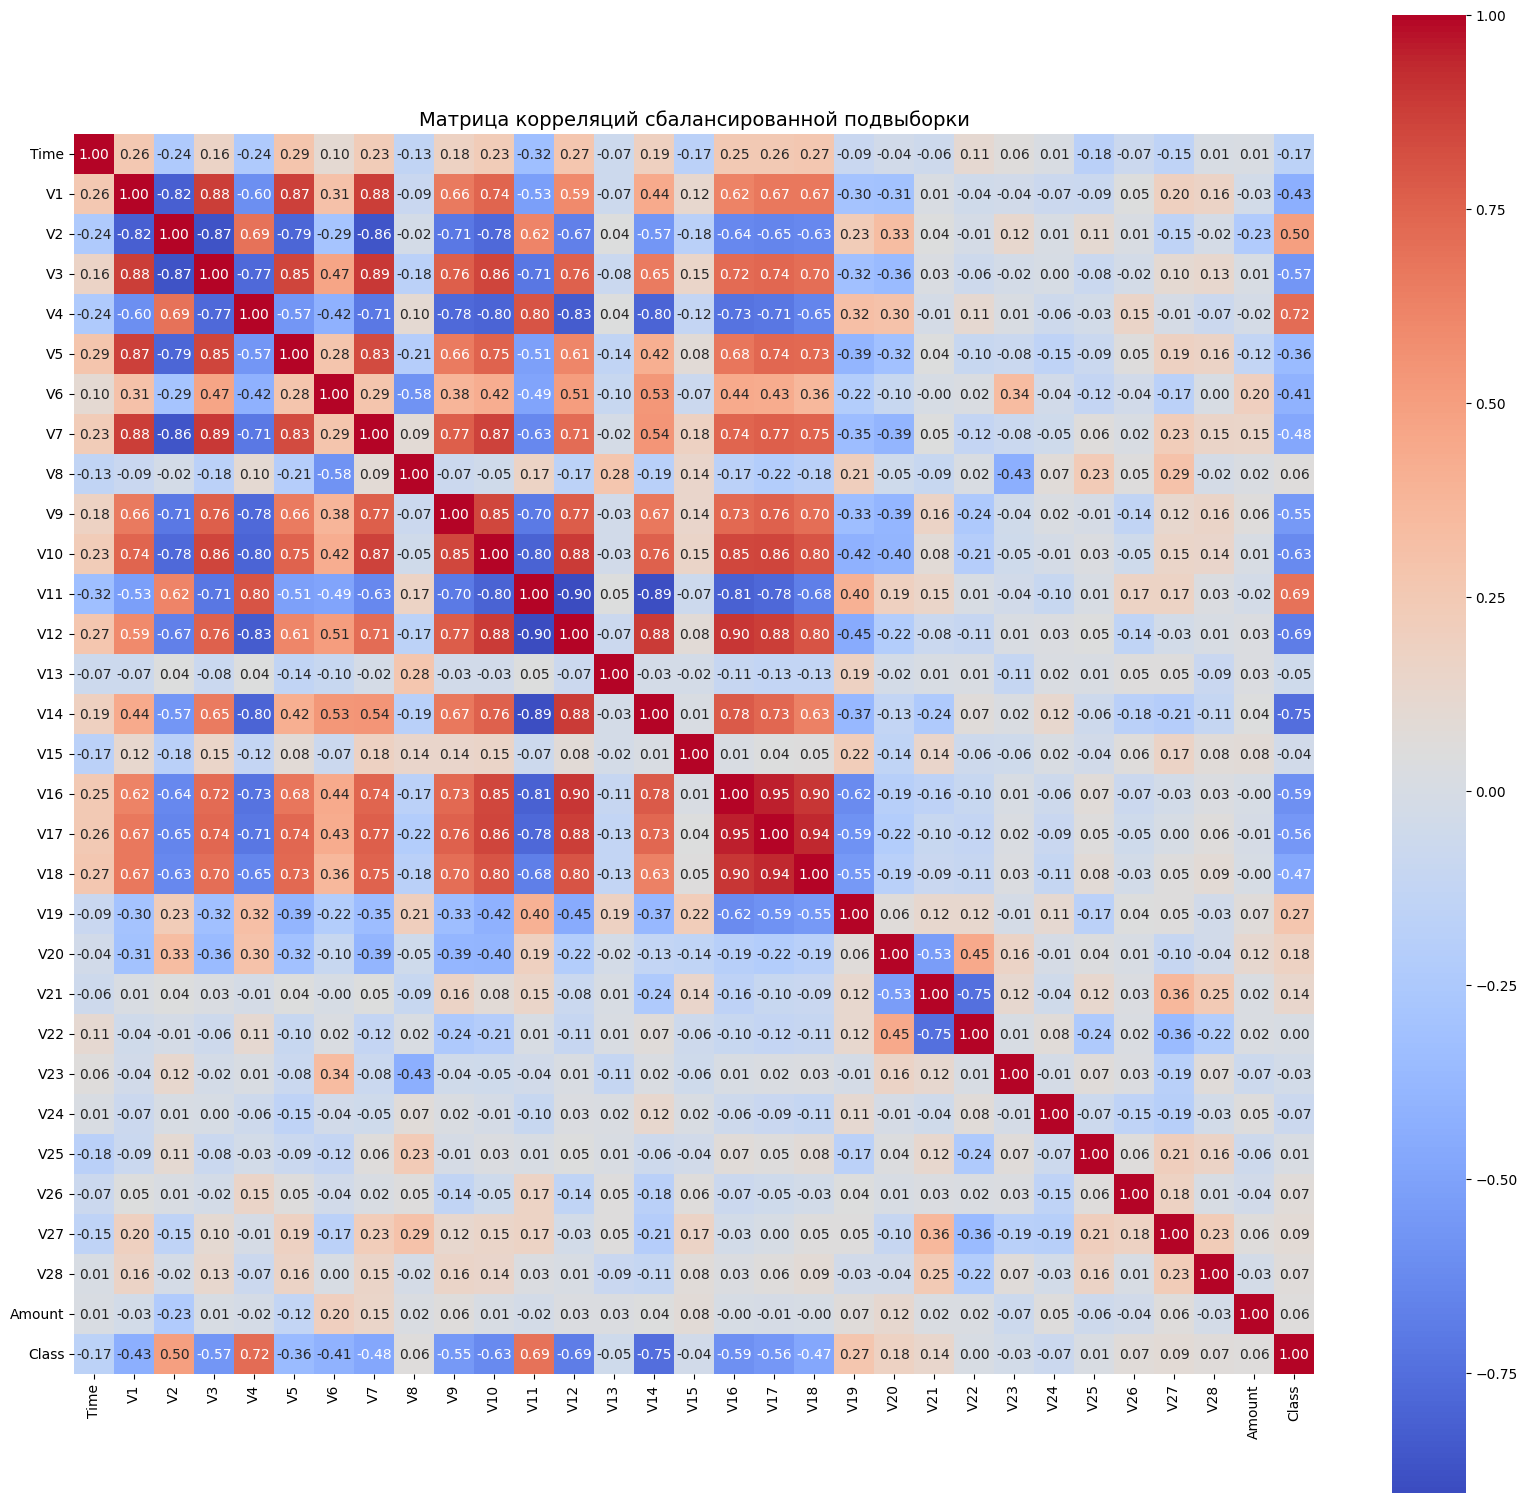

In [15]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))
correlation_matrix = new_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax, square=True, cbar_kws={"shrink": .8})
ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)
plt.show()

Выводы:


Отрицательные корреляции: Какие признаки имеют отрицательную корреляцию? Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.
Положительные корреляции: Какие признаки положительно коррелируют? То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.
Отрицательная корреляция: 10, 12, 14, 17

Положительная корреляция: 2, 4, 11, 19

Построим теперь Boxplot.

In [16]:
# Отрицательные корреляции
neg_corr_features = ['V10', 'V12', 'V14', 'V17']
# Положительные корреляции
pos_corr_features = ['V2', 'V4', 'V11', 'V19']

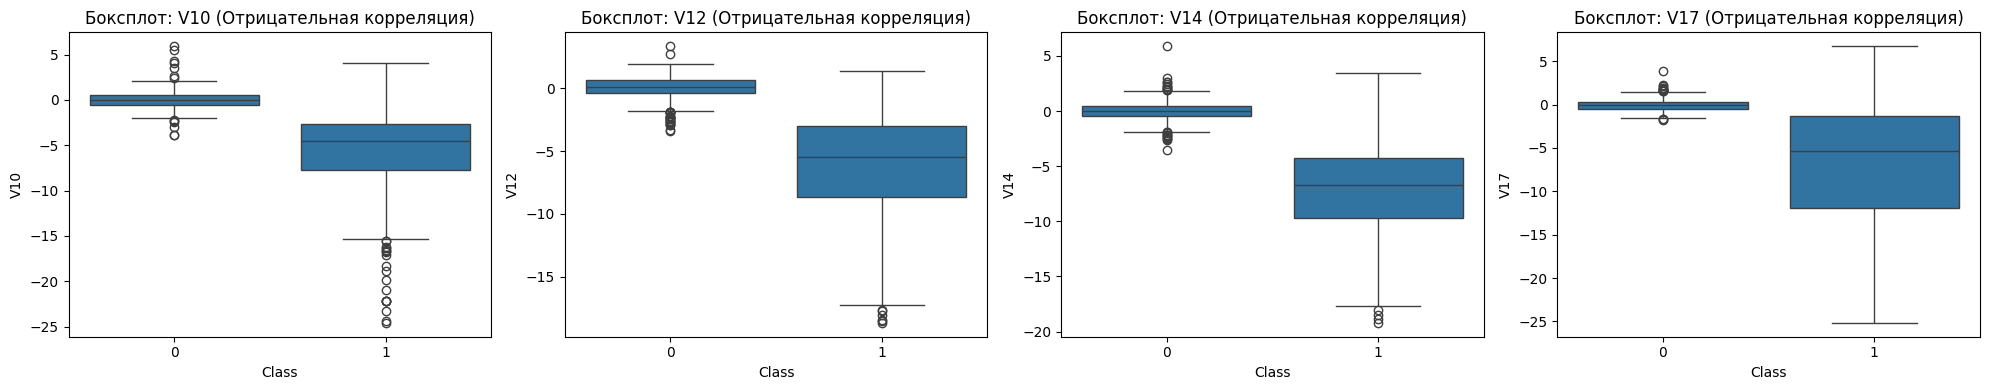

In [17]:
# Создаем подграфики для отрицательных корреляций
f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Боксплоты для отрицательных корреляций
for ax, feature in zip(axes, neg_corr_features):
    sns.boxplot(x='Class', y=feature, data=new_df, ax=ax)
    ax.set_title(f'Боксплот: {feature} (Отрицательная корреляция)')
    ax.set_xlabel('Class')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

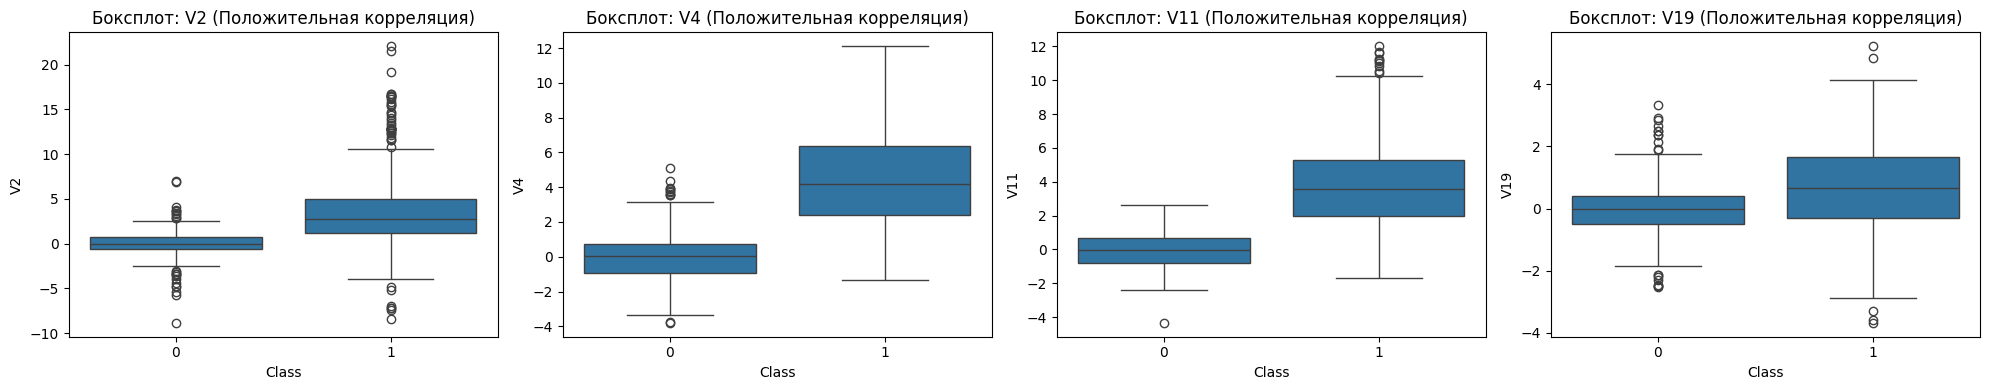

In [18]:
# Создаем подграфики для положительных корреляций
f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Боксплоты для отрицательных корреляций
for ax, feature in zip(axes, pos_corr_features):
    sns.boxplot(x='Class', y=feature, data=new_df, ax=ax)
    ax.set_title(f'Боксплот: {feature} (Положительная корреляция)')
    ax.set_xlabel('Class')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

0 - это не мошеннические транзакции

1 - мошеннические транзакции

Interquartile Range (IQR): Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.
Построить Boxplots: С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы.


Итого:
Строим распределения
Определяем порог
Удаляем выбросы
Строим Boxplot

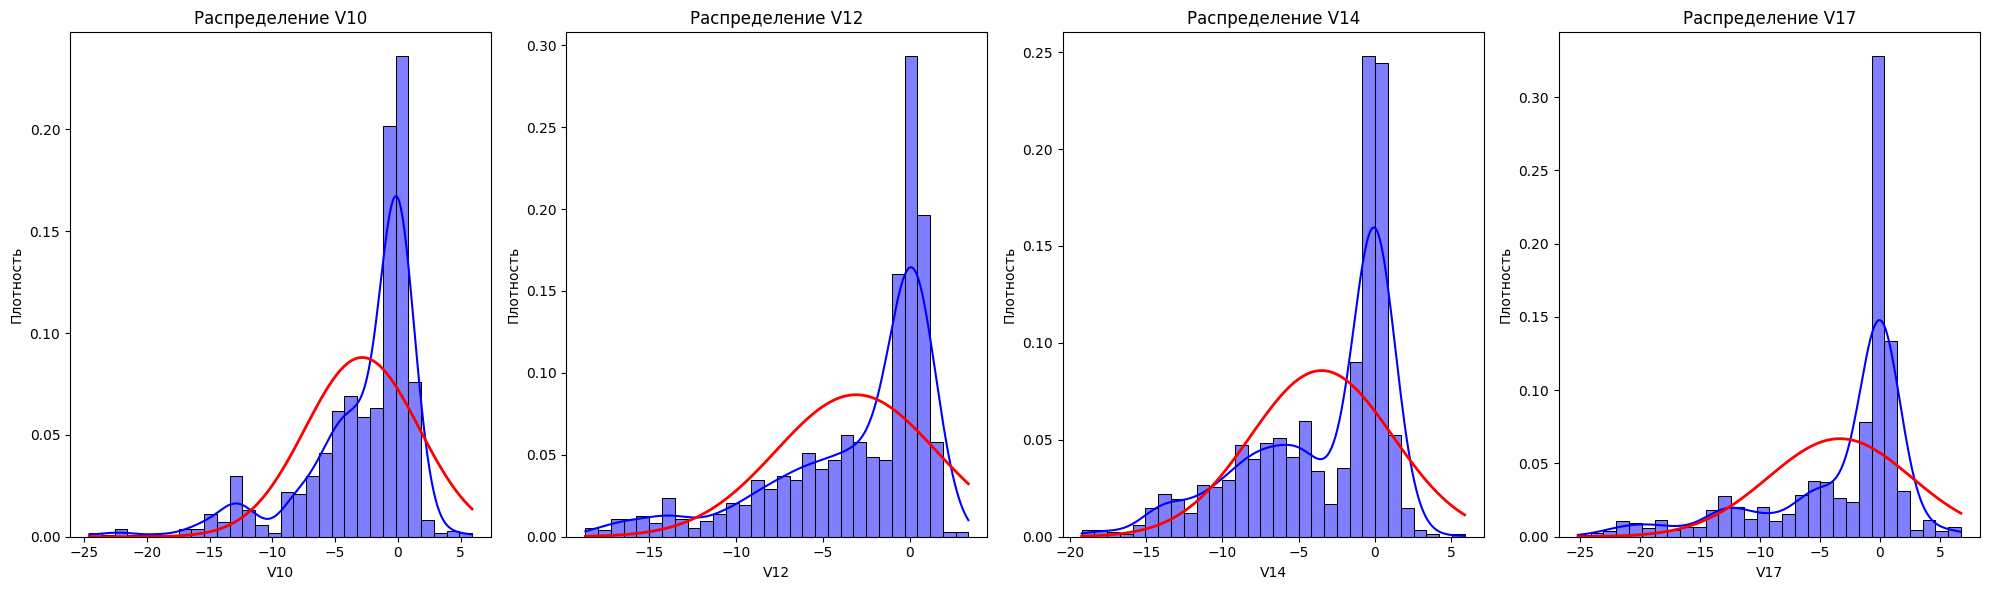

In [20]:
# Строим распределения для признаков с отрицательной корреляцией
from scipy.stats import norm
# Настройка графиков
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

# Строим распределение для каждого признака
for ax, feature in zip((ax1, ax2, ax3, ax4), neg_corr_features):
    # Гистограмма
    sns.histplot(new_df[feature], ax=ax, kde=True, stat="density", color='blue', bins=30)

    # Кривая нормального распределения
    mu, std = norm.fit(new_df[feature])
    x = np.linspace(new_df[feature].min(), new_df[feature].max(), 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)

    # Настройка заголовка и меток
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

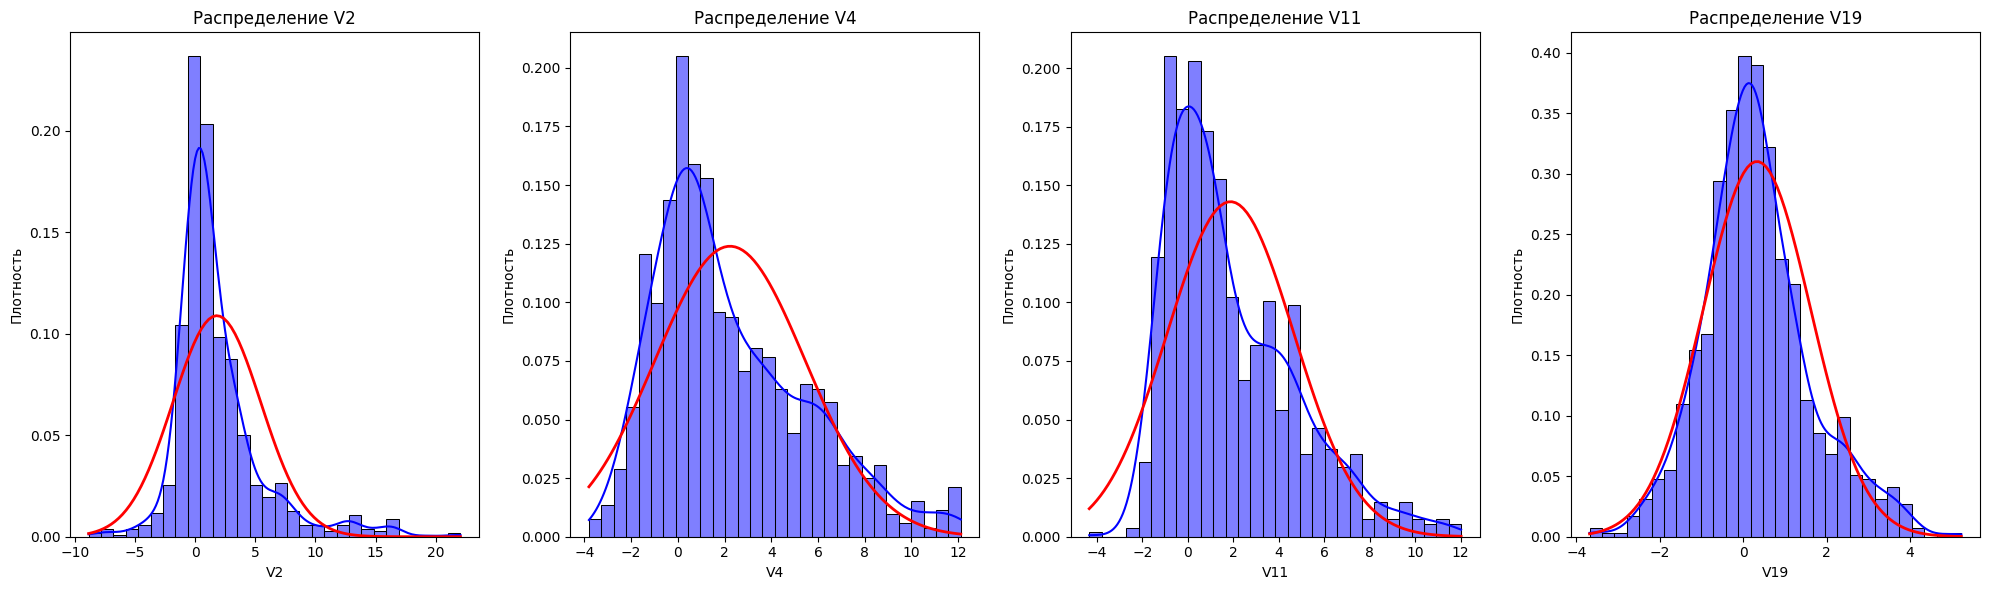

In [21]:
# Строим распределения для признаков с положительной корреляцией
from scipy.stats import norm
# Настройка графиков
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

# Строим распределение для каждого признака
for ax, feature in zip((ax1, ax2, ax3, ax4), pos_corr_features):
    # Гистограмма
    sns.histplot(new_df[feature], ax=ax, kde=True, stat="density", color='blue', bins=30)

    # Кривая нормального распределения
    mu, std = norm.fit(new_df[feature])
    x = np.linspace(new_df[feature].min(), new_df[feature].max(), 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)

    # Настройка заголовка и меток
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

In [22]:
# Функция для удаления выбросов
def remove_outliers(df, feature, target_class):
    # Извлечение значений признака для целевого класса
    feature_values = df[feature].loc[df['Class'] == target_class].values

    # Вычисление квартилей и межквартильного размаха (IQR)
    q25, q75 = np.percentile(feature_values, 25), np.percentile(feature_values, 75)
    iqr = q75 - q25

    # Определение порогов выбросов
    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off

    # Удаление выбросов
    outliers = df[(df[feature] > upper_bound) | (df[feature] < lower_bound)].index
    df_without_outliers = df.drop(outliers)

    print(f'Для признака {feature}:')
    print(f'Квартиль 25: {q25} | Квартиль 75: {q75}')
    print(f'IQR: {iqr}')
    print(f'Порог: {cut_off}')
    print(f'{feature} нижняя граница: {lower_bound}')
    print(f'{feature} верхняя граница: {upper_bound}')
    print(f'Количество выбросов: {len(outliers)}')
    print('----' * 20)

    return df_without_outliers

In [23]:
df_without_outliers = new_df.copy()
df_without_outliers

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
253522,156294.0,2.021996,-0.224932,-1.244309,0.216455,0.035434,-0.598639,-0.003892,-0.077159,0.470474,...,-0.265387,-0.729382,0.290938,-0.495281,-0.329922,0.211092,-0.080520,-0.075617,9.99,0
195383,131024.0,0.469750,-1.237555,-1.767341,4.833490,-0.268715,-0.512760,1.140149,-0.341273,-1.046351,...,0.303905,-0.647075,-0.373014,0.260801,-0.496566,-0.245973,-0.117858,0.144774,723.21,1
183016,125619.0,2.148601,0.004208,-1.736080,0.120361,0.503625,-0.766331,0.261912,-0.362036,0.609469,...,0.180837,0.716446,-0.132735,-0.955747,0.420281,-0.047417,-0.018314,-0.068449,1.00,0
83053,59669.0,0.326007,1.286638,-2.007181,2.419675,-1.532902,-1.432803,-2.459530,0.617738,-1.125861,...,0.556895,0.169776,-0.174357,0.308061,0.710996,-0.231030,0.580495,0.300984,6.27,1
46998,43028.0,-1.109646,0.811069,-1.138135,0.935265,-2.330248,-0.116106,-1.621986,0.458028,-0.912189,...,0.641594,0.841755,0.176728,0.081004,-0.258899,0.707654,0.418649,0.080756,204.27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64460,51155.0,-11.205461,7.914633,-13.987752,4.333341,-8.484970,-3.506561,-8.935243,7.704449,-2.336584,...,0.942593,-0.987848,-0.279446,-0.027299,0.644344,-0.263078,1.084023,0.211933,99.99,1
150601,93742.0,-3.291125,4.401194,-8.394212,4.453580,-4.790055,-4.240182,-9.219001,1.974030,-2.912943,...,2.102343,0.597370,-0.328086,0.445752,0.585281,-0.399005,2.116004,1.050744,1.00,1
224425,143786.0,-0.143217,0.943000,-0.978137,-0.013022,0.064332,-1.204983,0.927199,0.125238,-0.217181,...,0.400189,0.981277,0.094783,-0.102726,-0.334688,-0.151473,-0.034494,0.043937,100.00,0
79536,58067.0,-0.264869,3.386140,-3.454997,4.367629,3.336060,-2.053918,0.256890,-2.957235,-2.855797,...,-1.394504,-0.166029,-1.452081,-0.251815,1.243461,0.452787,0.132218,0.424599,1.00,1


In [24]:
for col in pos_corr_features + neg_corr_features:
    df_without_outliers = remove_outliers(df_without_outliers, col, 1)

Для признака V2:
Квартиль 25: 1.1882258198658224 | Квартиль 75: 4.9712573249056025
IQR: 3.78303150503978
Порог: 5.67454725755967
V2 нижняя граница: -4.486321437693848
V2 верхняя граница: 10.645804582465273
Количество выбросов: 51
--------------------------------------------------------------------------------
Для признака V4:
Квартиль 25: 2.232581359919345 | Квартиль 75: 6.070560404747405
IQR: 3.8379790448280597
Порог: 5.756968567242089
V4 нижняя граница: -3.5243872073227442
V4 верхняя граница: 11.827528971989494
Количество выбросов: 7
--------------------------------------------------------------------------------
Для признака V11:
Квартиль 25: 1.90399926160786 | Квартиль 75: 5.26786160380362
IQR: 3.3638623421957603
Порог: 5.04579351329364
V11 нижняя граница: -3.14179425168578
V11 верхняя граница: 10.31365511709726
Количество выбросов: 11
--------------------------------------------------------------------------------
Для признака V19:
Квартиль 25: -0.415741147664133 | Квартиль 75: 1.

In [25]:
df_without_outliers

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
253522,156294.0,2.021996,-0.224932,-1.244309,0.216455,0.035434,-0.598639,-0.003892,-0.077159,0.470474,...,-0.265387,-0.729382,0.290938,-0.495281,-0.329922,0.211092,-0.080520,-0.075617,9.99,0
195383,131024.0,0.469750,-1.237555,-1.767341,4.833490,-0.268715,-0.512760,1.140149,-0.341273,-1.046351,...,0.303905,-0.647075,-0.373014,0.260801,-0.496566,-0.245973,-0.117858,0.144774,723.21,1
183016,125619.0,2.148601,0.004208,-1.736080,0.120361,0.503625,-0.766331,0.261912,-0.362036,0.609469,...,0.180837,0.716446,-0.132735,-0.955747,0.420281,-0.047417,-0.018314,-0.068449,1.00,0
83053,59669.0,0.326007,1.286638,-2.007181,2.419675,-1.532902,-1.432803,-2.459530,0.617738,-1.125861,...,0.556895,0.169776,-0.174357,0.308061,0.710996,-0.231030,0.580495,0.300984,6.27,1
46998,43028.0,-1.109646,0.811069,-1.138135,0.935265,-2.330248,-0.116106,-1.621986,0.458028,-0.912189,...,0.641594,0.841755,0.176728,0.081004,-0.258899,0.707654,0.418649,0.080756,204.27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153885,100501.0,-6.985267,5.151094,-4.599338,4.534479,0.849054,-0.210701,-4.425230,-5.134525,0.069321,...,5.453672,-2.056177,-0.280334,0.120771,0.569358,0.145971,0.300193,1.779364,0.76,1
64460,51155.0,-11.205461,7.914633,-13.987752,4.333341,-8.484970,-3.506561,-8.935243,7.704449,-2.336584,...,0.942593,-0.987848,-0.279446,-0.027299,0.644344,-0.263078,1.084023,0.211933,99.99,1
224425,143786.0,-0.143217,0.943000,-0.978137,-0.013022,0.064332,-1.204983,0.927199,0.125238,-0.217181,...,0.400189,0.981277,0.094783,-0.102726,-0.334688,-0.151473,-0.034494,0.043937,100.00,0
79536,58067.0,-0.264869,3.386140,-3.454997,4.367629,3.336060,-2.053918,0.256890,-2.957235,-2.855797,...,-1.394504,-0.166029,-1.452081,-0.251815,1.243461,0.452787,0.132218,0.424599,1.00,1


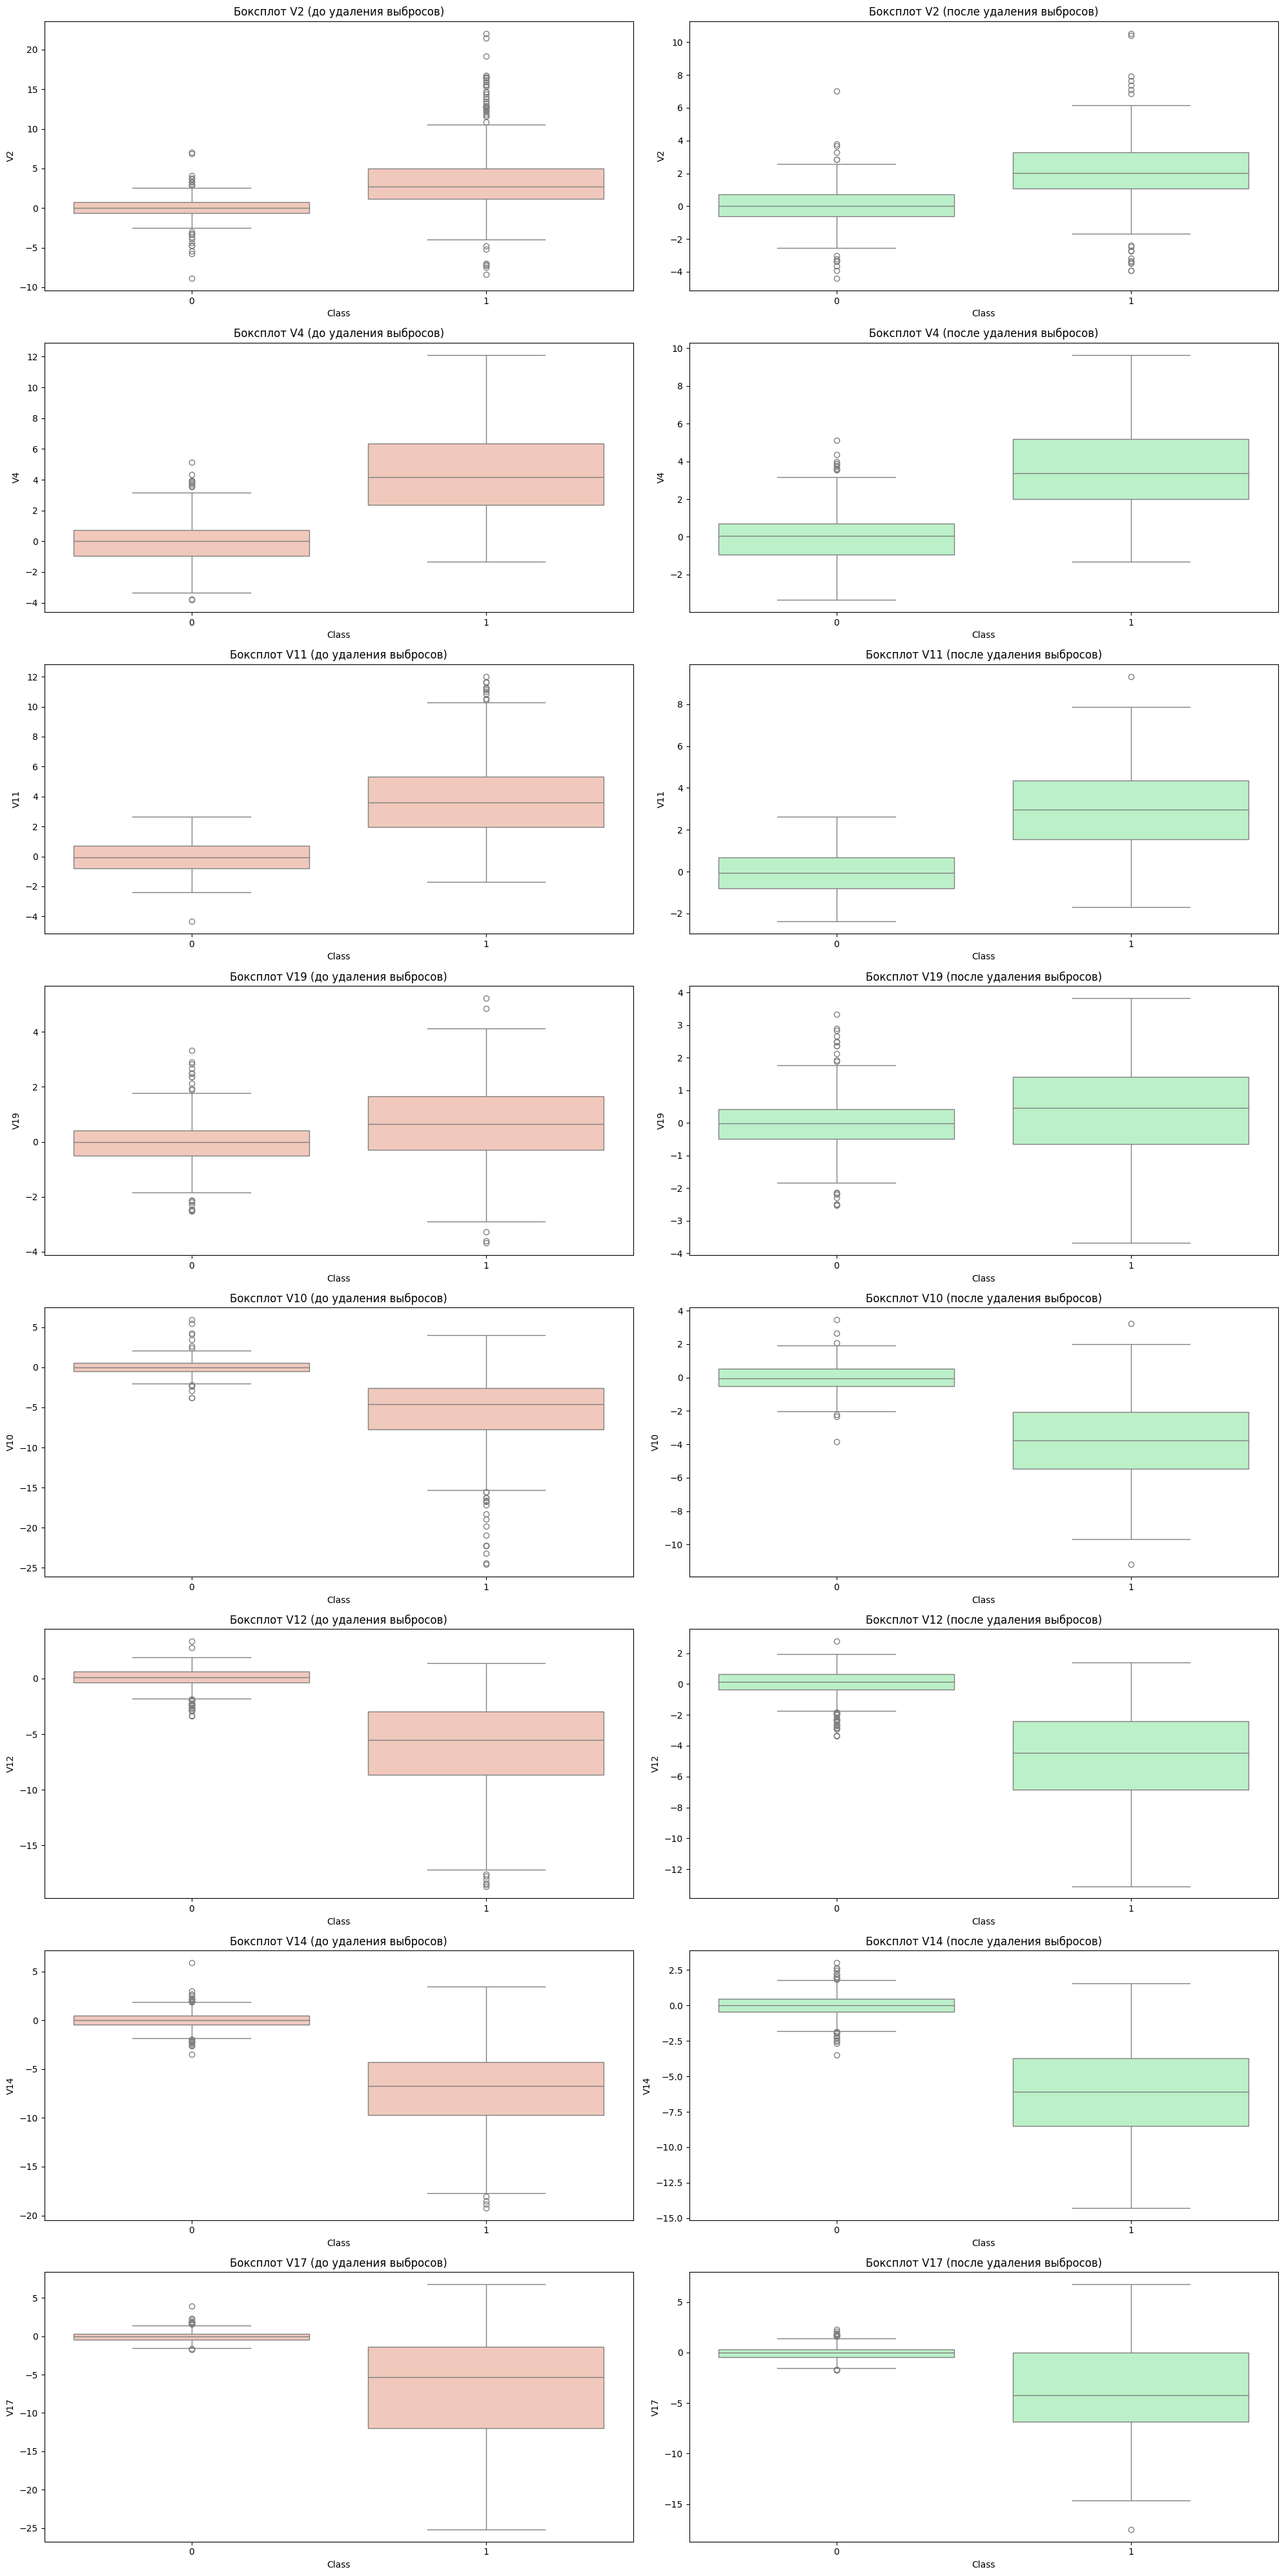

In [26]:
# Настройка графиков
f, ax = plt.subplots(8, 2, figsize=(20, 40))
colors = ['#B3F9C5', '#f9c5b3']

features = pos_corr_features + neg_corr_features

for i, feature in enumerate(features):
    # Боксплот до удаления выбросов
    sns.boxplot(x='Class', y=feature, data=new_df, ax=ax[i, 0], color=colors[1])
    ax[i, 0].set_title(f'Боксплот {feature} (до удаления выбросов)')

    # Боксплот после удаления выбросов
    sns.boxplot(x='Class', y=feature, data=df_without_outliers, ax=ax[i, 1], color=colors[0])
    ax[i, 1].set_title(f'Боксплот {feature} (после удаления выбросов)')

plt.tight_layout()
plt.show()

In [27]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = df_without_outliers

# Понижение размерности и кластеризация
Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.

In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом


# T-SNE алгоритм
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
svd = TruncatedSVD(n_components=2)
X_reduced_svd = svd.fit_transform(X)
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 7.7 сек
PCA заняло 0.025 сек
Truncated SVD заняло 0.037 сек


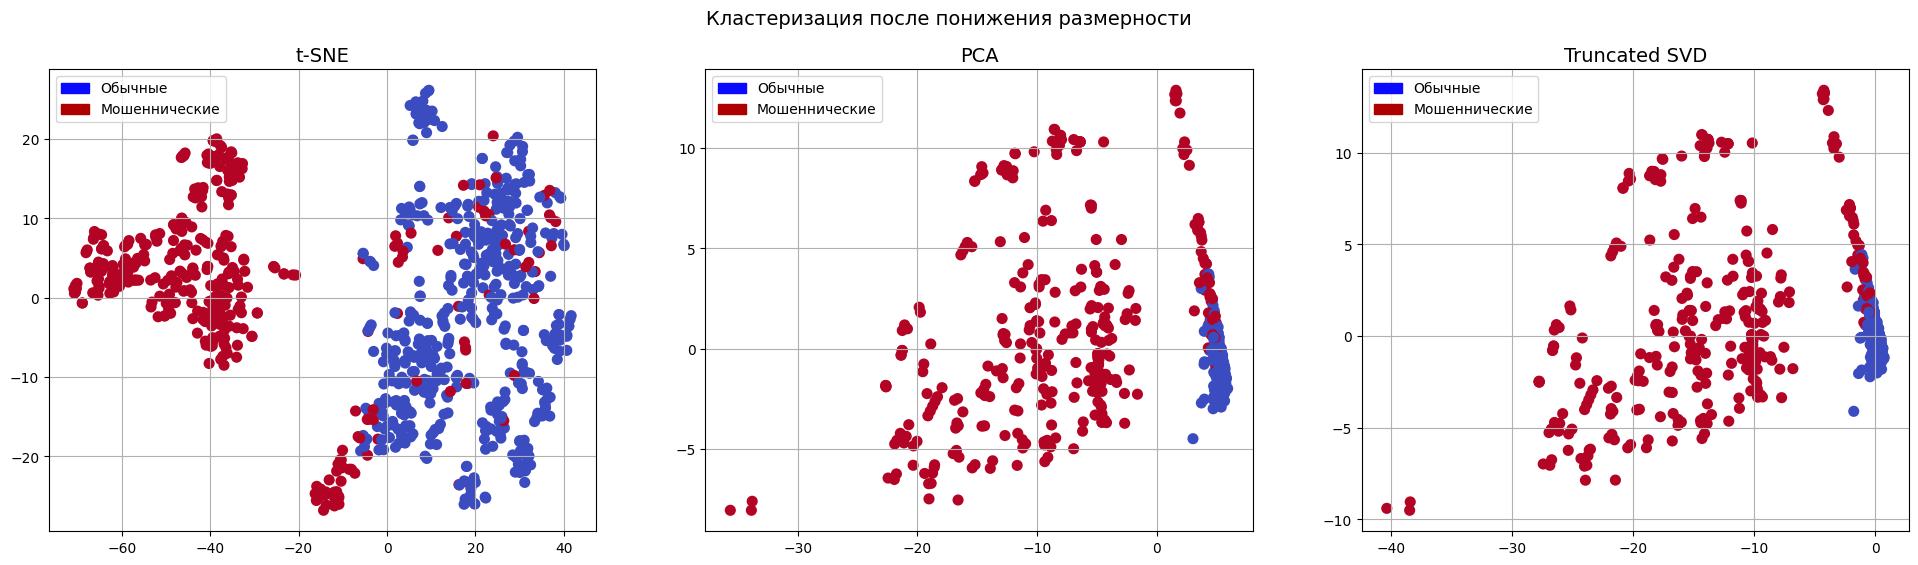

In [29]:
# Настройка графиков
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

# Создаем легенду
blue_patch = mpatches.Patch(color='#0A0AFF', label='Обычные')
red_patch = mpatches.Patch(color='#AF0000', label='Мошеннические')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y, cmap='coolwarm', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y, cmap='coolwarm', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=y, cmap='coolwarm', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Выводы:
Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных.
Классы целевой переменной однозначно разделимы, а значит мы можем строить модели!